# 📡 QPSK: Single-Carrier vs OFDM (1 Subcarrier) + Channel, Fading & BER


This notebook explores:
- **QPSK single-carrier vs OFDM (1 subcarrier)**
- **AWGN channel**
- **Fading & multipath channels**
- **Bit Error Rate (BER) analysis**

Each step includes code, comments, and visualizations.


## 🔹 Setup & Symbol Generation

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve, lfilter
from scipy.fft import fft, ifft
from numpy.random import default_rng

rng = default_rng(42)

# Parameters
num_symbols = 1000
samples_per_symbol = 8
fs = 1e4
fc = 2e3
rolloff = 0.35
span = 6
fft_size = 64
cp_length = 16
snr_db = 15

# QPSK Modulation
bits = rng.integers(0, 2, 2 * num_symbols)
symbols = (2 * bits[::2] - 1) + 1j * (2 * bits[1::2] - 1)
symbols /= np.sqrt(2)


## 🔸 Single-Carrier QPSK Modulation with Pulse Shaping

In [2]:

def rrc_filter(beta, sps, span):
    N = span * sps
    t = np.arange(-N / 2, N / 2 + 1) / sps
    h = np.sinc(t) * np.cos(np.pi * beta * t) / (1 - (2 * beta * t)**2)
    h[t == 0.5 / beta] = np.pi / 4 * np.sinc(1 / (2 * beta))
    h[t == -0.5 / beta] = np.pi / 4 * np.sinc(1 / (2 * beta))
    return h / np.sqrt(np.sum(h**2))

pulse = rrc_filter(rolloff, samples_per_symbol, span)
i_upsampled = np.zeros(num_symbols * samples_per_symbol)
q_upsampled = np.zeros_like(i_upsampled)
i_upsampled[::samples_per_symbol] = np.real(symbols)
q_upsampled[::samples_per_symbol] = np.imag(symbols)
i_shaped = convolve(i_upsampled, pulse, mode='same')
q_shaped = convolve(q_upsampled, pulse, mode='same')
baseband = i_shaped + 1j * q_shaped
t_total = np.arange(len(baseband)) / fs
carrier = np.exp(1j * 2 * np.pi * fc * t_total)
rf_sc = np.real(baseband * carrier)


## 🔸 OFDM Modulation (One Subcarrier)

In [3]:

ofdm_symbols = symbols[:len(symbols)]
ofdm_grid = np.zeros((len(ofdm_symbols), fft_size), dtype=complex)
ofdm_grid[:, 1] = ofdm_symbols
ofdm_time = ifft(ofdm_grid, axis=1)
ofdm_with_cp = np.hstack([ofdm_time[:, -cp_length:], ofdm_time])
ofdm_serial = ofdm_with_cp.ravel()
t_ofdm = np.arange(len(ofdm_serial)) / fs
carrier_ofdm = np.exp(1j * 2 * np.pi * fc * t_ofdm)
rf_ofdm = np.real(ofdm_serial * carrier_ofdm)


## 🌐 Channel: Fading + Multipath

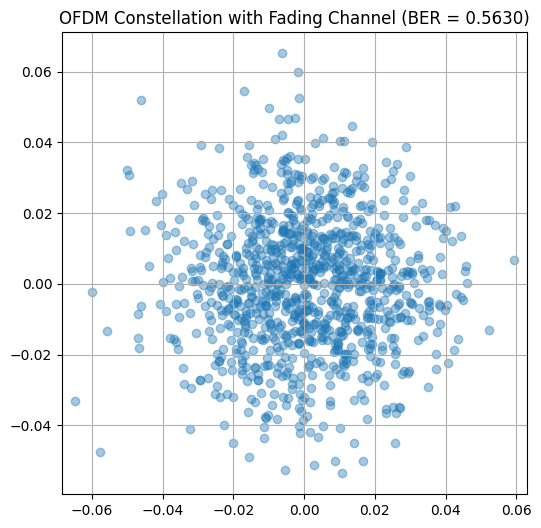

In [4]:

def fading_channel(signal, snr_db, taps=[1, 0.5 + 0.5j, 0.3], delays=[0, 3, 7]):
    h = np.zeros(delays[-1] + 1, dtype=complex)
    for i, d in enumerate(delays):
        h[d] = taps[i]
    faded = np.convolve(signal, h, mode='same')
    signal_power = np.mean(np.abs(faded)**2)
    snr_linear = 10**(snr_db / 10)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power / 2) * (rng.standard_normal(len(faded)) + 1j * rng.standard_normal(len(faded)))
    return faded + noise, h

# Transmit OFDM through fading channel
rx_ofdm_raw, h_true = fading_channel(ofdm_serial, snr_db)
rx_down = rx_ofdm_raw * np.exp(-1j * 2 * np.pi * fc * t_ofdm)
rx_blocks = rx_down.reshape((-1, fft_size + cp_length))[:, cp_length:]
rx_freq = fft(rx_blocks, axis=1)
rx_symbols = rx_freq[:, 1] / np.sum(h_true)  # simple equalizer

# BER
rx_bits = np.empty(2 * len(rx_symbols), dtype=int)
rx_bits[0::2] = np.real(rx_symbols) > 0
rx_bits[1::2] = np.imag(rx_symbols) > 0
ber = np.mean(rx_bits != bits[:len(rx_bits)])

plt.figure(figsize=(6, 6))
plt.scatter(np.real(rx_symbols), np.imag(rx_symbols), alpha=0.4)
plt.title(f"OFDM Constellation with Fading Channel (BER = {ber:.4f})")
plt.grid(True); plt.axis("equal"); plt.show()
